In [1]:
#%%capture
!pip uninstall jax jaxlib -y
!pip install --upgrade "jax[cuda11_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install --upgrade einops optax equinox jax-tqdm 


Found existing installation: jax 0.4.12
Uninstalling jax-0.4.12:
  Successfully uninstalled jax-0.4.12
Found existing installation: jaxlib 0.4.12+cuda11.cudnn86
Uninstalling jaxlib-0.4.12+cuda11.cudnn86:
  Successfully uninstalled jaxlib-0.4.12+cuda11.cudnn86
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
  Using cached jax-0.4.12-py3-none-any.whl
  Using cached https://storage.googleapis.com/jax-releases/cuda11/jaxlib-0.4.12%2Bcuda11.cudnn86-cp310-cp310-manylinux2014_x86_64.whl (188.3 MB)


In [2]:
import jax
jax.devices()

[gpu(id=0)]

In [3]:
from jax import random, value_and_grad, lax, vmap
from optax import adam, sgd, apply_updates, chain, clip, softmax_cross_entropy_with_integer_labels
from einops import rearrange, reduce, repeat
from functools import partial
from tqdm.notebook import tqdm
import equinox as eqx
import tensorflow_datasets as tfds
import tensorflow as tf
from jax.random import split, normal, randint
from jax.nn import relu, gelu, sigmoid, softmax
from jax import disable_jit
from jax.tree_util import tree_map, tree_leaves
import jax
from jax_tqdm import scan_tqdm
from jax import lax
import jax.numpy as jnp

import copy
import matplotlib.pyplot as plt

# Typing 
from jax import Array
from typing import Optional, Sequence, Tuple, Any
from jax.random import PRNGKeyArray

SEED = 0
MODEL_KEY = random.PRNGKey(SEED)
TEST_KEY = random.PRNGKey(SEED + 1)
TRAIN_KEY = random.PRNGKey(SEED + 2)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
N_CHARACTERS = 20

def extraction(image, label):
    # This function will shrink the Omniglot images to the desired size,
    # scale pixel values and convert the RGB image to grayscale
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize(image, [28, 28])
    return image, label


with jax.default_device(jax.devices("cpu")[0]):
    data = tfds.load("omniglot", split=["train+test"], data_dir="data", as_supervised=True, shuffle_files=False)[0]
    data = data.map(extraction)
    data_img, data_labels = [jnp.array(i) for i in list(zip(*data.as_numpy_iterator()))]
    data_img = rearrange(data_img, "b h w c -> b c h w")


In [5]:
# sort the data set
with jax.default_device(jax.devices("cpu")[0]):

    indices_sorted_labels = sorted(range(len(data_labels)), key=lambda k: data_labels[k])
    sorted_data_labels = data_labels[jnp.array(indices_sorted_labels)]
    sorted_data_img = data_img[jnp.array(indices_sorted_labels)]

sorted_data_img_split = rearrange(sorted_data_img, "(l i) c h w -> l i c h w", i=20)

In [6]:
# Randomly select 1200 characters to meta train on.
# Meta test on the rest.
n_meta_train = 1200

perm = random.permutation(MODEL_KEY, 1623)
scrambled_data_img_split = sorted_data_img_split[perm]

meta_train, meta_train_labels = scrambled_data_img_split[:n_meta_train], perm[:n_meta_train]
meta_test, meta_test_labels = scrambled_data_img_split[n_meta_train:], perm[n_meta_train:]

# meta train on the 1200 first characters
#meta_train_labels = jnp.concatenate((sorted_train_labels, sorted_test_labels[0:237*20]))
#meta_train = jnp.concatenate((sorted_train, sorted_test[0:237*20]))

# meta test on the remaining
#meta_test_labels = sorted_test_labels[237*20:]
#meta_test = sorted_test[237*20:]

In [7]:
import jax.experimental.mesh_utils as mesh_utils
import jax.sharding as sharding

num_devices = len(jax.devices())

img_devices = mesh_utils.create_device_mesh((num_devices,1,1,1,1))
img_shard = sharding.PositionalSharding(img_devices)

label_devices = mesh_utils.create_device_mesh((num_devices,))
label_shard = sharding.PositionalSharding(label_devices)

print(meta_train_labels.shape)

meta_train = jax.device_put(meta_train, img_shard)
meta_train_labels = jax.device_put(meta_train_labels, label_shard)
meta_test = jax.device_put(meta_test[1:], img_shard)
meta_test_labels = jax.device_put(meta_test_labels[1:], label_shard)

(1200,)


1487


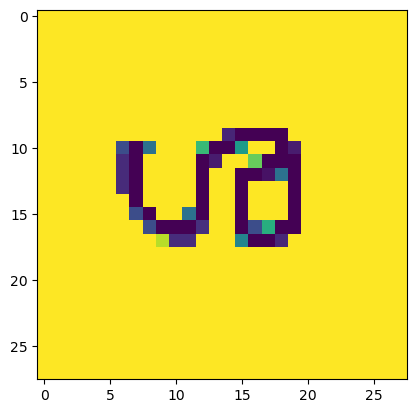

In [8]:
test_img = meta_train[469][15]
print(meta_train_labels[1103])
plt.imshow(test_img[0])
plt.show()

In [9]:
print(meta_train_labels.shape)
print(meta_train.shape)
print(meta_test_labels.shape)
print(meta_test.shape)

(1200,)
(1200, 20, 1, 28, 28)
(422,)
(422, 20, 1, 28, 28)


In [10]:
def multi_batch_loss(model_alpha, batch_loss, batch_of_tasks, inner_step, inner_optim, inner_opt_state) -> Array:
    """Compute the loss over all models"""

    # get model_i', test_i, test_labels_i for all tasks i: # 
    train_imgs, train_labels, test_imgs, test_labels = batch_of_tasks
    # vmap over tasks inner step
    models = eqx.filter_vmap(inner_step,in_axes=(None,0,0,None,None,None))(model_alpha, train_imgs, train_labels, 
                                                                batch_loss,inner_optim, inner_opt_state)
    # sum loss_i(model_i', test_i, test_labels_i)
    return eqx.filter_vmap(batch_loss)(models, test_imgs, test_labels).sum()

In [11]:
def batch_loss(model, images: Array, labels: Array) -> Array:
    '''Compute the loss.'''

    def loss(image: Array, label: Array):
        pred = model(image)

        return  softmax_cross_entropy_with_integer_labels(pred,label)

    # Mean over the batch
    return vmap(loss)(images, labels).mean()

In [12]:
def task_update(model_alpha, train, train_labels, inner_step, inner_optim, inner_opt_state, batch_loss):
    model_i = inner_step(model_alpha, train, train_labels, batch_loss, inner_optim, inner_opt_state)  # compute model_i'
    return model_i

In [13]:
@partial(eqx.filter_jit,donate="all")
def outer_step_METASGD(model_alpha, batch_loss, outer_optim, outer_opt_state,
                       inner_step, batch_of_tasks, inner_optim, inner_opt_state):
    """"""
    loss, grads = eqx.filter_value_and_grad(multi_batch_loss)(model_alpha, batch_loss, batch_of_tasks, 
                                                              inner_step, inner_optim, inner_opt_state)  # Compute loss and gradient, meta step
    updates, outer_opt_state = outer_optim.update(grads, outer_opt_state, model_alpha)  
    model_alpha = eqx.apply_updates(model_alpha, updates)  
    return loss, model_alpha, outer_opt_state

In [14]:
def inner_step_METASGD(model_alpha, train, train_labels, batch_loss, inner_optim, inner_opt_state):

    model, alpha = copy.deepcopy(model_alpha[0]), model_alpha[1] 
    loss, grad = eqx.filter_value_and_grad(batch_loss)(model, train, train_labels)  # Compute loss and gradient
    mod_grad = tree_map(lambda x,y: x*y, grad, alpha)  # replace standard gradient with alpha*gradient (elementwise product)
    updates, opt_state = inner_optim.update(mod_grad, inner_opt_state, model)  
    model = eqx.apply_updates(model, updates)  

    return model

In [15]:
#keys = split(MODEL_KEY, 20)
#ks = random.randint(keys[0],(N_CHARACTERS,),minval=0, maxval=4)
#roted_imgs_test = eqx.filter_vmap(rot90_traceable,in_axes=(None,0))(sorted_data_img_split[0][0], ks)

def rot90_traceable(m, k, axes=(1, 2)):
    return jax.lax.switch(k, [partial(jnp.rot90, m, k=i, axes=axes) for i in range(4)])

def augmentation(imgs, key):
    keys = split(key, N_CHARACTERS)
    ks = random.randint(keys[0],(N_CHARACTERS,),minval=0, maxval=4)
    #roted_imgs_test = eqx.filter_vmap(rot90_traceable,in_axes=(None,0))(imgs, ks)
    roted_imgs = eqx.filter_vmap(rot90_traceable)(imgs, ks)
    return roted_imgs


In [16]:
"""N-way K-shot classification tasks"""

@partial(eqx.filter_jit,donate="all")
def load_batch_of_tasks(meta_set, n_char, n_train, n_test, train_key, do_augmentation=True):  
    # return one task with n_char characters 
    # for each character we have n_train train images and n_test test images

    meta_set_images, meta_set_labels = meta_set
    
    # load n_char random characters/labels from the relevant labels 
    size_meta_set =meta_set_labels.size
    random_indices = random.choice(train_key, jnp.arange(size_meta_set), replace=False, shape=(n_char,))
    labels = meta_set_labels[random_indices]

    keys = split(train_key, n_char)

    def char_data(char_indx, key, n_train, n_test):
        # given a character/label, return the character together with 
        # n_train train images and n_test test_images (randomly chosen)
        # all images should correspond to the char label 
        rot_key, perm_key = split(key)

        char_images = meta_set_images[char_indx]  # 20 instances 
        if do_augmentation:
            char_images = augmentation(char_images, rot_key)  # perform rotations
        perm_char_images = char_images[random.permutation(perm_key,N_CHARACTERS)]
        train_instances, test_instances = perm_char_images[:n_train], perm_char_images[N_CHARACTERS-n_test: N_CHARACTERS]

        return train_instances, test_instances

    train_imgs, test_imgs = eqx.filter_vmap(char_data,in_axes=(0,0,None,None))(random_indices, keys, n_train, n_test)

    # reshape the data 

    train_labels, test_labels = jnp.repeat(labels, n_train), jnp.repeat(labels, n_test)

    train_imgs = rearrange(train_imgs, "n_char n_inst c h w -> (n_char n_inst) c h w")
    test_imgs = rearrange(test_imgs, "n_char n_inst c h w -> (n_char n_inst) c h w")

    return train_imgs, train_labels, test_imgs, test_labels


In [17]:
# Load batch of tasks
nr_of_tasks = 32  # total number of tasks

train_keys = split(TRAIN_KEY,nr_of_tasks)

# task specific parameters
nr_char = 2  # number of characters
nr_train = 3  # number of training images for each character
nr_test = 5  # number of testing images for each character

# Batch: 
train_imgs, train_labels, test_imgs, test_labels = eqx.filter_vmap(load_batch_of_tasks, in_axes=(None, None, None,None,0))((meta_train, meta_train_labels), nr_char, nr_train, nr_test, train_keys)

In [18]:
print(train_imgs.shape)
print(train_labels.shape)
print(test_imgs.shape)
print(test_labels.shape)

(32, 6, 1, 28, 28)
(32, 6)
(32, 10, 1, 28, 28)
(32, 10)


In [19]:
print(train_labels[0])

[ 700  700  700 1313 1313 1313]


631


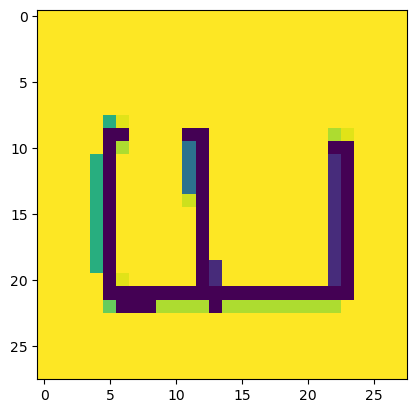

In [20]:
# indexing batch of tasks 
task, char, image =  2, 0, 0
#test_img = train_imgs[task][nr_train*char+image]
test_img = test_imgs[task][nr_test*char+image]
test_img_label = test_labels[task][nr_test*char+image]
print(test_img_label)
plt.imshow(test_img[0])
plt.show()

In [21]:
# Meta training
#epochs = 4000
epochs = 60000
#meta_batch_size = 16
meta_batch_size = 32
test_keys = random.split(TEST_KEY, epochs)
train_keys = random.split(TRAIN_KEY, epochs)

# task specific parameters
nr_char = 5  # number of characters
nr_train = 5  # number of training images for each character
nr_test = 15  # number of testing images for each character

In [ ]:
# META SGD
img_size = (1,28,28)
depth, width, height, = img_size

# Initialize the optimizer

Ravel = eqx.nn.Lambda(lambda img : img.ravel())
Relu = eqx.nn.Lambda(relu)

#model = eqx.nn.Sequential([Ravel,
#    eqx.nn.MLP(depth*width*height,1623,128,2,key=MODEL_KEY)])

#Following [7], we use a
#convolution architecture with 4 modules, where each module consists of 3 × 3 convolutions, followed
#by batch normalization [11], a ReLU nonlinearity, and 2 × 2 max-pooling. For Omniglot, the images
#are downsampled to 28 × 28, and we use 64 filters and add an additional fully-connected layer with
#dimensionality 32 after the convolution modules.


keys = split(MODEL_KEY,5)

generate_module = lambda in_channels, key : eqx.nn.Sequential([
                                eqx.nn.Conv2d(in_channels,64,3,1,1,key=key),
                                #eqx.nn.BatchNorm(64,0),
                                Relu, 
                                eqx.nn.MaxPool2d(2,2),
                                ])

model = eqx.nn.Sequential([generate_module(c,key) for key, c in zip(keys[:4],(1,64,64,64))] + 
                          [Ravel,eqx.nn.Linear(64,1623,key=keys[4])])


alpha = copy.deepcopy(eqx.filter(model,eqx.is_array))
init_const = 0.05  # should be between 0.005 and 0.1
alpha = tree_map(lambda x: init_const*jnp.ones(shape=x.shape), alpha)
#beta = 0.0001  # outer loop LR, constant
#outer_optim = adam(3e-4, eps=1e-04)
outer_optim = adam(1e-3)
outer_opt_state = outer_optim.init(eqx.filter((model,alpha), eqx.is_array))  
inner_optim = sgd(1) 
inner_opt_state = inner_optim.init(eqx.filter(model, eqx.is_array))

dynamic_model, static_model = eqx.partition(model, eqx.is_array)

@scan_tqdm(epochs)
def scan_fun(carry,i):
    dynamic_model, alpha, outer_opt_state = carry
    train_keys_batch = random.split(train_keys[i], meta_batch_size)
    batch_of_tasks = eqx.filter_vmap(load_batch_of_tasks, in_axes=(None, None, None, None, 0))((meta_train, meta_train_labels), nr_char, nr_train, nr_test, train_keys_batch)
    loss, (model, alpha), outer_opt_state = outer_step_METASGD((eqx.combine(dynamic_model,static_model), alpha), batch_loss, outer_optim, outer_opt_state,
                                                    inner_step_METASGD, batch_of_tasks, inner_optim, inner_opt_state)
    return (eqx.partition(model, eqx.is_array)[0], alpha, outer_opt_state), loss

carry = (dynamic_model, alpha, outer_opt_state)
(dynamic_model, alpha, outer_opt_state), losses = lax.scan(scan_fun,carry,jnp.arange(epochs))

model = eqx.combine(dynamic_model,static_model)

  0%|          | 0/60000 [00:00<?, ?it/s]

In [ ]:
eqx.tree_serialise_leaves("model_alpha.eqx", (model,alpha))

In [ ]:
import matplotlib.pyplot as plt
#plt.plot(losses[losses < 10])
plt.plot(losses)
plt.show()
losses[-1000:].mean()

In [ ]:
# load evaluation task
train_keys = split(TRAIN_KEY+1,1)
# meta training set (performs well on meta training set):
#train_imgs, train_labels, test_imgs, test_labels = eqx.filter_vmap(load_batch_of_tasks, in_axes=(None, None, None,None,0,None))((meta_train, meta_train_labels), nr_char, nr_train, nr_test, train_keys,False)
# meta testing set (not as good at meta testing set...):
train_imgs, train_labels, test_imgs, test_labels = eqx.filter_vmap(load_batch_of_tasks, in_axes=(None, None, None,None,0))((meta_test, meta_test_labels), nr_char, nr_train, nr_test, train_keys)

In [ ]:
test_model = inner_step_METASGD((model,alpha), train_imgs[0], train_labels[0], batch_loss, inner_optim, inner_opt_state,)

In [ ]:
test_model

In [ ]:
#task, char, image =  0, 0, 2
task, char, image =  0, 0, 10

test_img = test_imgs[task][nr_test*char+image]
test_img_label = test_labels[task][nr_test*char+image]

print(test_img_label)
plt.imshow(test_img[0])
plt.show()

In [ ]:
pred = softmax(test_model(test_img))
print(jnp.argmax(pred))

In [ ]:
test_model(test_img)
plt.bar(range(5),softmax(test_model(test_img))[jnp.unique(test_labels)])
plt.show()
jnp.unique(test_labels)

In [ ]:
#conv = eqx.nn.Sequential([generate_module(c,key) for key, c in zip(keys[:4],(1,64,64,64))] + 
#                          [Ravel,eqx.nn.Linear(64,1623,key=keys[4])])

#model_loaded = eqx.tree_deserialise_leaves("/kaggle/input/model1/model (1).eqx", conv)
